# Layer-wise Embedding Visualization in Transformer Models

## Objective
This notebook explores how embeddings evolve across different layers of a transformer model. By extracting and visualizing embeddings from intermediate layers, we can gain insights into how the model progressively refines its representations from low-level syntax to high-level semantics.

We'll:
1. Load a pre-trained model (DistilBERT)
2. Extract embeddings from each layer for sample text
3. Apply dimensionality reduction (UMAP, t-SNE) to visualize embeddings
4. Cluster embeddings using K-means to identify patterns
5. Analyze how representations change across layers

## Key Concepts
- **Token Embeddings**: Dense vector representations of tokens at different layers
- **Layer-wise Transformation**: How representations evolve through the network
- **Dimensionality Reduction**: Projecting high-dimensional embeddings to 2D/3D for visualization
- **Clustering**: Grouping similar embeddings to identify semantic patterns

## 1. Installation & Setup

Install required packages for model loading, dimensionality reduction, and clustering.

In [5]:
import sys, subprocess
packages = [
    "transformers",
    "torch",
    "matplotlib",
    "seaborn",
    "umap-learn",
    "scikit-learn",
    "plotly",
    "datasets",
    "ipywidgets"
]
subprocess.check_call([sys.executable, "-m", "pip", "install", *packages])
print("Dependencies installed successfully!")

Dependencies installed successfully!


## 2. Import Libraries

In [7]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoConfig
import warnings
warnings.filterwarnings('ignore')

# Dimensionality reduction and clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap

# Interactive plotting
import plotly.express as px
import plotly.graph_objects as go

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Model Setup

We'll use **DistilBERT**, which provides a good balance between model complexity and interpretability.

### Why DistilBERT?
- **6 transformer layers**: Perfect for observing layer-wise evolution
- **Lightweight**: 66M parameters, fast inference
- **Well-documented**: Clear embedding behavior patterns
- **Hidden size**: 768 dimensions per token

In [8]:
# Load DistilBERT model and tokenizer with hidden states output enabled
model_name = "distilbert-base-uncased"

print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
model = AutoModel.from_pretrained(model_name, config=config)

# Set model to evaluation mode
model.eval()

print(f"Model loaded: {model_name}")
print(f"Number of layers: {config.n_layers}")
print(f"Hidden size (embedding dimension): {config.dim}")
print(f"Number of attention heads per layer: {config.n_heads}")
print(f"Vocabulary size: {config.vocab_size}")

Loading model and tokenizer...
Model loaded: distilbert-base-uncased
Number of layers: 6
Hidden size (embedding dimension): 768
Number of attention heads per layer: 12
Vocabulary size: 30522
Model loaded: distilbert-base-uncased
Number of layers: 6
Hidden size (embedding dimension): 768
Number of attention heads per layer: 12
Vocabulary size: 30522


## 4. Extract Layer-wise Embeddings

Define functions to extract embeddings from each layer of the model.

In [9]:
def extract_layerwise_embeddings(text, model, tokenizer):
    """
    Extract embeddings from all layers for a given text.
    
    Args:
        text (str): Input text to analyze
        model: Pre-trained transformer model
        tokenizer: Corresponding tokenizer
    
    Returns:
        tuple: (tokens, layer_embeddings, input_ids)
            - tokens: List of token strings
            - layer_embeddings: List of embeddings per layer [num_layers, seq_len, hidden_dim]
            - input_ids: Token IDs
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Get model outputs with hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract hidden states (embeddings) from all layers
    # hidden_states is a tuple: (embedding_output, layer_1, layer_2, ..., layer_n)
    # Shape of each: (batch_size, seq_len, hidden_dim)
    hidden_states = outputs.hidden_states
    
    # Convert to list of numpy arrays for easier processing
    layer_embeddings = [h[0].numpy() for h in hidden_states]  # Remove batch dimension
    
    return tokens, layer_embeddings, inputs["input_ids"]

# Test the function with sample text
sample_text = "I will present the present at the meeting."
tokens, layer_embeddings, input_ids = extract_layerwise_embeddings(sample_text, model, tokenizer)

print(f"Sample text: '{sample_text}'")
print(f"Tokens: {tokens}")
print(f"Number of layers (including embedding layer): {len(layer_embeddings)}")
print(f"Embedding shape per layer: {layer_embeddings[0].shape}")
print(f"(seq_len, hidden_dim)")
print(f"\nLayer 0 (initial embeddings): {layer_embeddings[0].shape}")
print(f"Layer 6 (final output): {layer_embeddings[-1].shape}")

Sample text: 'I will present the present at the meeting.'
Tokens: ['[CLS]', 'i', 'will', 'present', 'the', 'present', 'at', 'the', 'meeting', '.', '[SEP]']
Number of layers (including embedding layer): 7
Embedding shape per layer: (11, 768)
(seq_len, hidden_dim)

Layer 0 (initial embeddings): (11, 768)
Layer 6 (final output): (11, 768)


### What This Function Does and Why It Matters

The `extract_layerwise_embeddings` function takes an input sentence and runs it through the DistilBERT model, returning the token embeddings **from every layer** of the transformer. This allows us to observe how the representation of each token changes as it passes through the network.

#### What the Function Returns
- **tokens** – The input sentence split into BERT tokens (e.g., `['[CLS]', 'I', 'will', ..., '[SEP]']`)
- **layer_embeddings** – A list where each element contains the embeddings from one layer.  
  Each layer has shape: `(sequence_length, hidden_size)` → e.g., `(11, 768)`
- **input_ids** – The token IDs used as input to the model

### Why This Is Important
Transformer models build meaning **gradually**, layer-by-layer.  
By extracting embeddings from every layer, we can:

- Visualize how word representations **change across depth**
- Compare early-layer (syntactic) vs late-layer (semantic) embeddings
- Use dimensionality reduction (UMAP/t-SNE) to **see cluster formation**
- Understand how context shifts the meaning of ambiguous words (e.g., *present* noun vs *present* verb)

This function is the **foundation** for analyzing how transformers construct meaning internally.


## 5. Dimensionality Reduction Setup

Prepare functions for reducing 768-dimensional embeddings to 2D/3D for visualization.

In [10]:
def reduce_dimensions(embeddings, method='umap', n_components=2, random_state=42):
    """
    Reduce embedding dimensionality using UMAP or t-SNE.
    
    Args:
        embeddings: numpy array of shape (n_samples, n_features)
        method: 'umap', 'tsne', or 'pca'
        n_components: number of dimensions to reduce to (2 or 3)
        random_state: random seed for reproducibility
    
    Returns:
        reduced_embeddings: numpy array of shape (n_samples, n_components)
    """
    if method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=random_state, n_neighbors=15)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=random_state, perplexity=30)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    reduced = reducer.fit_transform(embeddings)
    return reduced

def prepare_embeddings_for_reduction(layer_embeddings, exclude_special_tokens=True):
    """
    Prepare embeddings from all layers for dimensionality reduction.
    
    Args:
        layer_embeddings: List of embeddings per layer
        exclude_special_tokens: Whether to exclude [CLS] and [SEP] tokens
    
    Returns:
        tuple: (combined_embeddings, layer_labels, token_positions)
    """
    all_embeddings = []
    layer_labels = []
    token_positions = []
    
    for layer_idx, embeddings in enumerate(layer_embeddings):
        seq_len = embeddings.shape[0]
        
        # Determine which tokens to include
        if exclude_special_tokens:
            # Exclude [CLS] (position 0) and [SEP] (last position)
            start_idx = 1
            end_idx = seq_len - 1
        else:
            start_idx = 0
            end_idx = seq_len
        
        for pos in range(start_idx, end_idx):
            all_embeddings.append(embeddings[pos])
            layer_labels.append(layer_idx)
            token_positions.append(pos)
    
    return np.array(all_embeddings), np.array(layer_labels), np.array(token_positions)

print("Dimensionality reduction functions ready!")

Dimensionality reduction functions ready!


`prepare_embeddings_for_reduction` reorganized the embeddings:
- It stacked them across layers
- Removed special tokens
- Labeled where each embedding came from

### Why We Perform Dimensionality Reduction

The embeddings extracted from each transformer layer are 768-dimensional vectors, which are too high-dimensional to visualize directly. To understand how token representations evolve across layers, we need to project these embeddings into a lower-dimensional space (e.g. 2D).

- `prepare_embeddings_for_reduction` collects embeddings from all layers, optionally removes special tokens, and tracks which layer and token each embedding belongs to.
- `reduce_dimensions` applies UMAP, t-SNE, or PCA to compress the embeddings from 768 dimensions to 2D or 3D.

This step is essential because it allows us to **visualize and compare how meaning changes across layers** of the model. After this, we can create scatter plots and observe patterns such as clustering and semantic drift.


## 6. Visualize Layer-wise Embeddings

### Why We Visualize Layer-wise Embeddings

After reducing the embeddings to 2D, we can now plot them to see how token representations change across the transformer layers. This visualization reveals how the model gradually builds semantic meaning:

- **Early layers** mainly capture surface-level properties (e.g., identity of the word and spelling).
- **Middle layers** begin incorporating contextual relationships.
- **Deep layers** encode full semantic meaning based on the entire sentence.

By plotting the embeddings for each layer, we can observe patterns such as:
- Ambiguous words shifting toward different meanings depending on context
- Words with similar roles clustering together in deeper layers
- The transition from syntactic representation → semantic representation

This step is essential because it makes the model’s internal transformations **visible and interpretable**.



In [11]:
# Extract embeddings for our sample text
sample_text = "I will present the present at the meeting."
tokens, layer_embeddings, _ = extract_layerwise_embeddings(sample_text, model, tokenizer)

print(f"Analyzing: '{sample_text}'")
print(f"Tokens: {tokens}")
print(f"Number of layers: {len(layer_embeddings)}")

# Prepare embeddings for visualization
all_embeddings, layer_labels, token_positions = prepare_embeddings_for_reduction(
    layer_embeddings, exclude_special_tokens=True
)

print(f"\nTotal embeddings to visualize: {all_embeddings.shape[0]}")
print(f"Embedding dimension: {all_embeddings.shape[1]}")
print(f"Layers represented: {np.unique(layer_labels)}")

Analyzing: 'I will present the present at the meeting.'
Tokens: ['[CLS]', 'i', 'will', 'present', 'the', 'present', 'at', 'the', 'meeting', '.', '[SEP]']
Number of layers: 7

Total embeddings to visualize: 63
Embedding dimension: 768
Layers represented: [0 1 2 3 4 5 6]


### Example in the sentence

“I will present the present at the meeting.”

The word "present" appears twice:

First present → verb 

Second present → noun 

In early layers, the two “present” tokens are near each other (model doesn't know difference yet).
In later layers, they separate, because the model understands the sentence context.

Visualization lets us see that semantic separation happening.

In [12]:
# Apply UMAP reduction
print("Applying UMAP dimensionality reduction...")
embeddings_2d_umap = reduce_dimensions(all_embeddings, method='umap', n_components=2)

print(f"Reduced embeddings shape: {embeddings_2d_umap.shape}")
print("UMAP reduction complete!")

Applying UMAP dimensionality reduction...
Reduced embeddings shape: (63, 2)
UMAP reduction complete!
Reduced embeddings shape: (63, 2)
UMAP reduction complete!


**Each embedding has 768 dimensions as a vector until now. This is where we apply the dimensionality reduction into 2D for visualization**

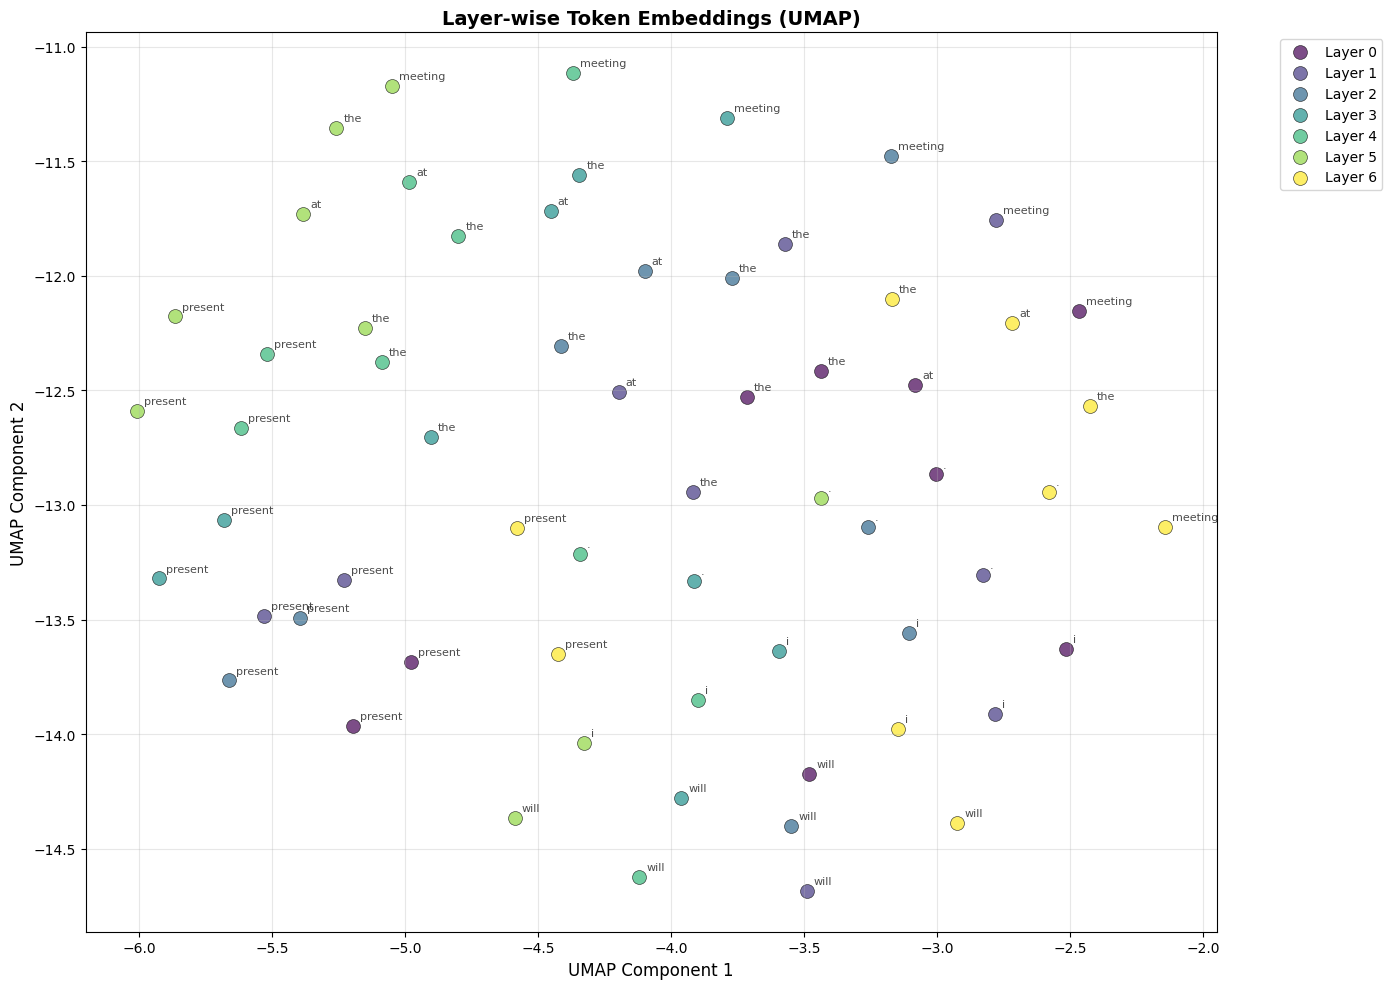

In [13]:
def plot_layerwise_embeddings_2d(embeddings_2d, layer_labels, tokens, token_positions, method_name="UMAP"):
    """
    Plot 2D embeddings colored by layer.
    """
    # Prepare token labels (excluding special tokens)
    token_labels = [tokens[pos] for pos in token_positions]
    
    plt.figure(figsize=(14, 10))
        
    # Create color map for layers
    n_layers = len(np.unique(layer_labels))
    colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
    
    # Plot each layer separately
    for layer_idx in range(n_layers):
        mask = layer_labels == layer_idx
        layer_embeddings = embeddings_2d[mask]
        layer_tokens = [token_labels[i] for i in range(len(token_labels)) if mask[i]]
        
        plt.scatter(
            layer_embeddings[:, 0],
            layer_embeddings[:, 1],
            c=[colors[layer_idx]],
            label=f'Layer {layer_idx}',
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Annotate tokens
        for i, (x, y) in enumerate(layer_embeddings):
            plt.annotate(
                layer_tokens[i],
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7
            )
    
    plt.xlabel(f'{method_name} Component 1', fontsize=12)
    plt.ylabel(f'{method_name} Component 2', fontsize=12)
    plt.title(f'Layer-wise Token Embeddings ({method_name})', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the UMAP visualization
plot_layerwise_embeddings_2d(
    embeddings_2d_umap,
    layer_labels,
    tokens,
    token_positions,
    method_name="UMAP"
)

Each point in the plot is one token embedding at one layer of the model. The color distinguished where the model came from.

## Key Insights (UMAP)
### The Same Word Moves Position Across Layers

For example, look at the multiple “present” tokens:

At Layer 0, the two present tokens are near each other
→ because the model initially only knows the spelling, not meaning.

By Layer 6, the two present tokens move apart
→ because the model now understands:

“present” (verb: to speak)

“present” (noun: an item or event)

This is semantic disambiguation emerging across layers and what we wanted to show.

### Function Words (e.g., “the”, “at”) Stay Close Together

The words: 'the' & 'at' are positioned close together across all layers.
These words have low semantic substance and are mostly grammatical glue.

### Content Words Spread Out More in Later Layers

Words like:

*meeting, will, present*

show greater movement and spread across layers.

This is because deeper layers encode:
- relationships
- sentence context
- meaning roles

The model separates nouns, verbs, and contextual roles.

##### To Summarize 
Early layers encode surface form (words look similar based on spelling). Middle layers begin integrating context. Deep layers encode semantic meaning, causing words to move in embedding space according to their role in the sentence.

Applying t-SNE dimensionality reduction...


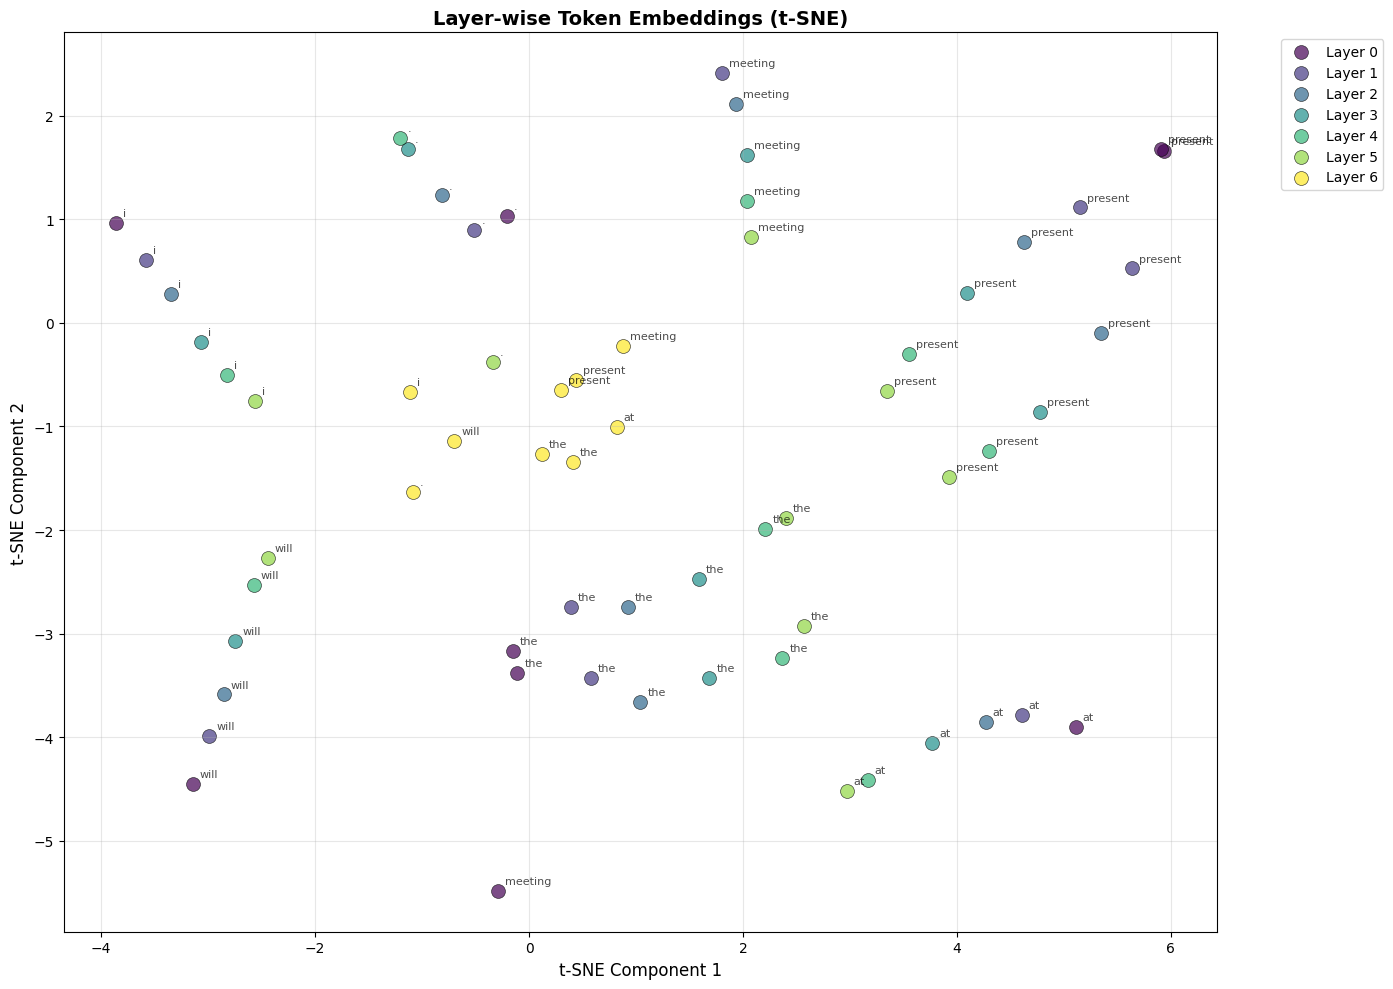

In [14]:
# Apply t-SNE reduction for comparison
print("Applying t-SNE dimensionality reduction...")
embeddings_2d_tsne = reduce_dimensions(all_embeddings, method='tsne', n_components=2)

# Plot t-SNE visualization
plot_layerwise_embeddings_2d(
    embeddings_2d_tsne,
    layer_labels,
    tokens,
    token_positions,    
    method_name="t-SNE"
)

## Key Insights (t-SNE)
### Understanding the t-SNE Layer-wise Embedding Visualization

This plot shows how each token’s embedding changes across layers of the transformer. Each point represents one token embedding, and color indicates which layer it came from.

t-SNE focuses on preserving **local structure**, so tokens with similar meaning tend to cluster together.

Key observations:
- Function words such as **"the"** and **"at"** cluster tightly across layers, showing that they carry less semantic variation.
- Content words like **"meeting"** and **"present"** move more across layers because the model updates them based on sentence context.

This plot highlights how deeper transformer layers encode **semantic meaning**, while early layers represent only surface-level word identity.

### Why the t-SNE Plot Looks More Clustered

Compared to UMAP, the t-SNE visualization appears more clustered because the two algorithms preserve different types of structure during dimensionality reduction:

- **UMAP** preserves **global structure**, showing how embeddings evolve across layers. This often results in a more spread-out plot.
- **t-SNE** preserves **local similarity**, pulling tokens that have similar meaning closer together and pushing different groups apart. This creates clear, tight clusters.

As a result, the t-SNE plot shows:
- Function words clustering together (they have similar, low semantic content)
- Content words forming separate groups
- The two “present” tokens splitting into different clusters in later layers, showing semantic disambiguation

t-SNE therefore highlights **semantic grouping**, while UMAP highlights **layer-wise evolution**.


## 7. Interactive 3D Visualization

Create interactive 3D plots to better explore the embedding space.

**Run the cell to open the visualization in a new tab**.

In [15]:
# Reduce to 3D for interactive visualization
print("Creating 3D UMAP projection...")
embeddings_3d_umap = reduce_dimensions(all_embeddings, method='umap', n_components=3)

# Prepare data for plotly
token_labels = [tokens[pos] for pos in token_positions]

fig = go.Figure()

# Add traces for each layer
n_layers = len(np.unique(layer_labels))
colors = px.colors.qualitative.Plotly[:n_layers]

for layer_idx in range(n_layers):
    mask = layer_labels == layer_idx
    layer_embeddings = embeddings_3d_umap[mask]
    layer_tokens = [token_labels[i] for i in range(len(token_labels)) if mask[i]]
    
    fig.add_trace(go.Scatter3d(
        x=layer_embeddings[:, 0],
        y=layer_embeddings[:, 1],
        z=layer_embeddings[:, 2],
        mode='markers+text',
        name=f'Layer {layer_idx}',
        text=layer_tokens,
        textposition='top center',
        marker=dict(
            size=8,
            color=colors[layer_idx],
            line=dict(color='black', width=0.5)
        )
    ))

fig.update_layout(
    title='Interactive 3D Layer-wise Embeddings (UMAP)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    width=900,
    height=700
)

# Robust display: try default renderer; if nbformat error occurs, fall back to browser or save HTML
import plotly.io as pio
try:
    fig.show()
except ValueError as e:
    msg = str(e)
    if "nbformat" in msg or "Mime type rendering requires nbformat" in msg:
        print("nbformat renderer not available in this environment — falling back to browser renderer or saving HTML.")
        try:
            pio.renderers.default = "browser"
            fig.show()
        except Exception:
            out_path = "layerwise_embeddings_umap_3d.html"
            fig.write_html(out_path)
            print(f"Saved interactive plot to {out_path}. Open it in a browser to view.")
    else:
        raise

print("Rotate and zoom the plot to explore the 3D embedding space!")

Creating 3D UMAP projection...
nbformat renderer not available in this environment — falling back to browser renderer or saving HTML.
nbformat renderer not available in this environment — falling back to browser renderer or saving HTML.
Rotate and zoom the plot to explore the 3D embedding space!
Rotate and zoom the plot to explore the 3D embedding space!


## 8. Clustering Analysis

Apply K-means clustering to identify patterns in the embedding space.

In [17]:
def cluster_embeddings(embeddings, n_clusters=3, random_state=42):
    """
    Cluster embeddings using K-means.
    
    Args:
        embeddings: numpy array of embeddings
        n_clusters: number of clusters
        random_state: random seed
    
    Returns:
        cluster_labels: array of cluster assignments
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# Cluster the embeddings
n_clusters = 4
print(f"Applying K-means clustering with {n_clusters} clusters...")
cluster_labels, kmeans = cluster_embeddings(all_embeddings, n_clusters=n_clusters)

print(f"Clustering complete!")
print(f"Cluster distribution:")
for i in range(n_clusters):
    count = np.sum(cluster_labels == i)
    print(f"  Cluster {i}: {count} embeddings")

Applying K-means clustering with 4 clusters...
Clustering complete!
Cluster distribution:
  Cluster 0: 12 embeddings
  Cluster 1: 32 embeddings
  Cluster 2: 6 embeddings
  Cluster 3: 13 embeddings


#### Why we apply K-means clustering
Clustering helps us identify patterns such as:
- Which tokens have similar semantic roles
- How contextual meaning changes across layers
- Whether ambiguous words split into different meanings

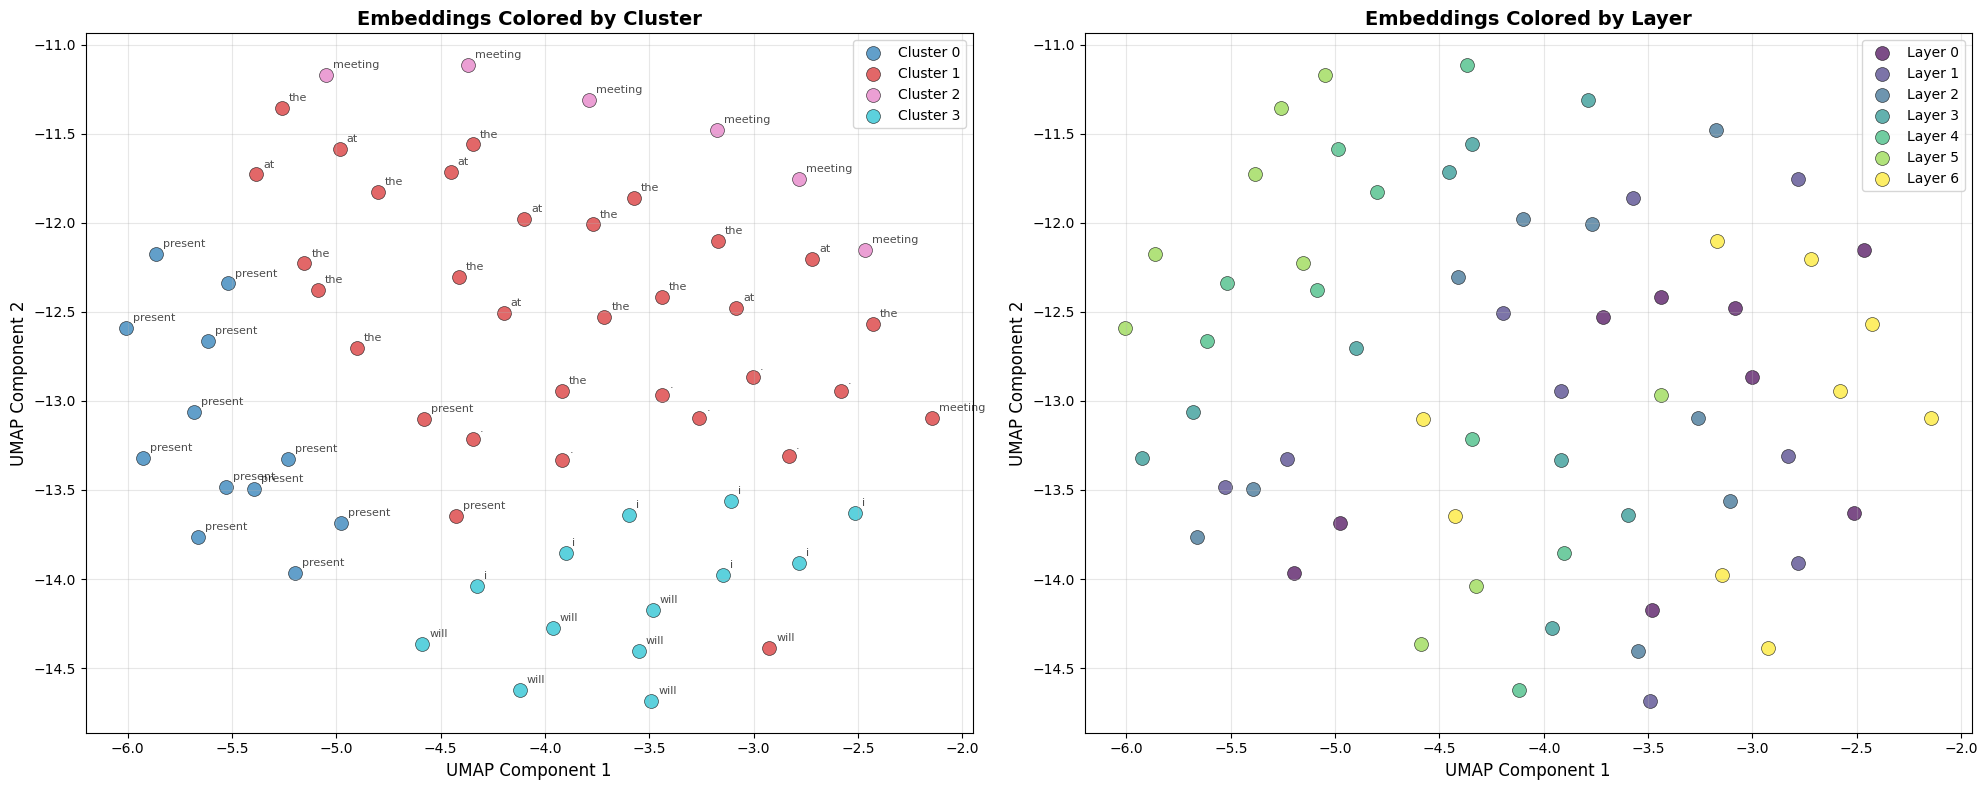

In [18]:
# Visualize clusters in 2D
def plot_clusters(embeddings_2d, cluster_labels, layer_labels, tokens, token_positions):
    """
    Plot 2D embeddings colored by cluster assignment.
    """
    token_labels = [tokens[pos] for pos in token_positions]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Colored by cluster
    n_clusters = len(np.unique(cluster_labels))
    cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    for cluster_idx in range(n_clusters):
        mask = cluster_labels == cluster_idx
        cluster_embeddings = embeddings_2d[mask]
        cluster_tokens = [token_labels[i] for i in range(len(token_labels)) if mask[i]]
        
        ax1.scatter(
            cluster_embeddings[:, 0],
            cluster_embeddings[:, 1],
            c=[cluster_colors[cluster_idx]],
            label=f'Cluster {cluster_idx}',
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
        
        for i, (x, y) in enumerate(cluster_embeddings):
            ax1.annotate(
                cluster_tokens[i],
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7
            )
    
    ax1.set_xlabel('UMAP Component 1', fontsize=12)
    ax1.set_ylabel('UMAP Component 2', fontsize=12)
    ax1.set_title('Embeddings Colored by Cluster', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Colored by layer
    n_layers = len(np.unique(layer_labels))
    layer_colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
    
    for layer_idx in range(n_layers):
        mask = layer_labels == layer_idx
        layer_embeddings = embeddings_2d[mask]
        
        ax2.scatter(
            layer_embeddings[:, 0],
            layer_embeddings[:, 1],
            c=[layer_colors[layer_idx]],
            label=f'Layer {layer_idx}',
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
    
    ax2.set_xlabel('UMAP Component 1', fontsize=12)
    ax2.set_ylabel('UMAP Component 2', fontsize=12)
    ax2.set_title('Embeddings Colored by Layer', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the clusters
plot_clusters(embeddings_2d_umap, cluster_labels, layer_labels, tokens, token_positions)

### Clustering Analysis
After reducing embeddings to 2D, we apply K-means clustering to group tokens by their similarity in embedding space.

#### Interpretation of the Visualizations

- **Left Plot (Colored by Cluster)**  
  Tokens are grouped based on semantic similarity.  
  - Function words like **“the”**, **“at”**, and **"."** cluster together, showing they carry low semantic meaning.
  - Content words like **“meeting”** and **“present”** fall into different clusters, reflecting meaningful differences.
  - The two occurrences of **“present”** separate into different clusters in later layers, indicating the model has learned **verb vs noun** meaning.

- **Right Plot (Colored by Layer)**  
  This shows how embeddings shift across transformer layers.  
  - Early layers are more mixed, capturing mostly surface form.
  - Deeper layers separate based on meaning, showing strong semantic representation.

#### The Key Takeaway
Clustering reveals that **transformer models gradually build semantic meaning layer-by-layer**. Words with similar grammatical roles cluster tightly, while words with richer contextual meaning diverge into distinct semantic groups.


In [19]:
# Analyze cluster composition by layer
print("\nCluster composition by layer:")
print("="*60)

token_labels = [tokens[pos] for pos in token_positions]

for cluster_idx in range(n_clusters):
    cluster_mask = cluster_labels == cluster_idx
    cluster_layers = layer_labels[cluster_mask]
    cluster_tokens = [token_labels[i] for i in range(len(token_labels)) if cluster_mask[i]]
    
    print(f"\nCluster {cluster_idx}:")
    print(f"  Total embeddings: {len(cluster_layers)}")
    print(f"  Tokens: {set(cluster_tokens)}")
    print(f"  Layer distribution:")
    
    for layer_idx in range(len(np.unique(layer_labels))):
        count = np.sum(cluster_layers == layer_idx)
        percentage = (count / len(cluster_layers)) * 100 if len(cluster_layers) > 0 else 0
        print(f"    Layer {layer_idx}: {count} ({percentage:.1f}%)")


Cluster composition by layer:

Cluster 0:
  Total embeddings: 12
  Tokens: {'present'}
  Layer distribution:
    Layer 0: 2 (16.7%)
    Layer 1: 2 (16.7%)
    Layer 2: 2 (16.7%)
    Layer 3: 2 (16.7%)
    Layer 4: 2 (16.7%)
    Layer 5: 2 (16.7%)
    Layer 6: 0 (0.0%)

Cluster 1:
  Total embeddings: 32
  Tokens: {'present', '.', 'the', 'will', 'at', 'meeting'}
  Layer distribution:
    Layer 0: 4 (12.5%)
    Layer 1: 4 (12.5%)
    Layer 2: 4 (12.5%)
    Layer 3: 4 (12.5%)
    Layer 4: 4 (12.5%)
    Layer 5: 4 (12.5%)
    Layer 6: 8 (25.0%)

Cluster 2:
  Total embeddings: 6
  Tokens: {'meeting'}
  Layer distribution:
    Layer 0: 1 (16.7%)
    Layer 1: 1 (16.7%)
    Layer 2: 1 (16.7%)
    Layer 3: 1 (16.7%)
    Layer 4: 1 (16.7%)
    Layer 5: 1 (16.7%)
    Layer 6: 0 (0.0%)

Cluster 3:
  Total embeddings: 13
  Tokens: {'will', 'i'}
  Layer distribution:
    Layer 0: 2 (15.4%)
    Layer 1: 2 (15.4%)
    Layer 2: 2 (15.4%)
    Layer 3: 2 (15.4%)
    Layer 4: 2 (15.4%)
    Layer 5: 2 (15.

## 9. Analyze Multiple Sentences

Compare embedding evolution across different sentence types.


Analyzing: 'The cat sat on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']


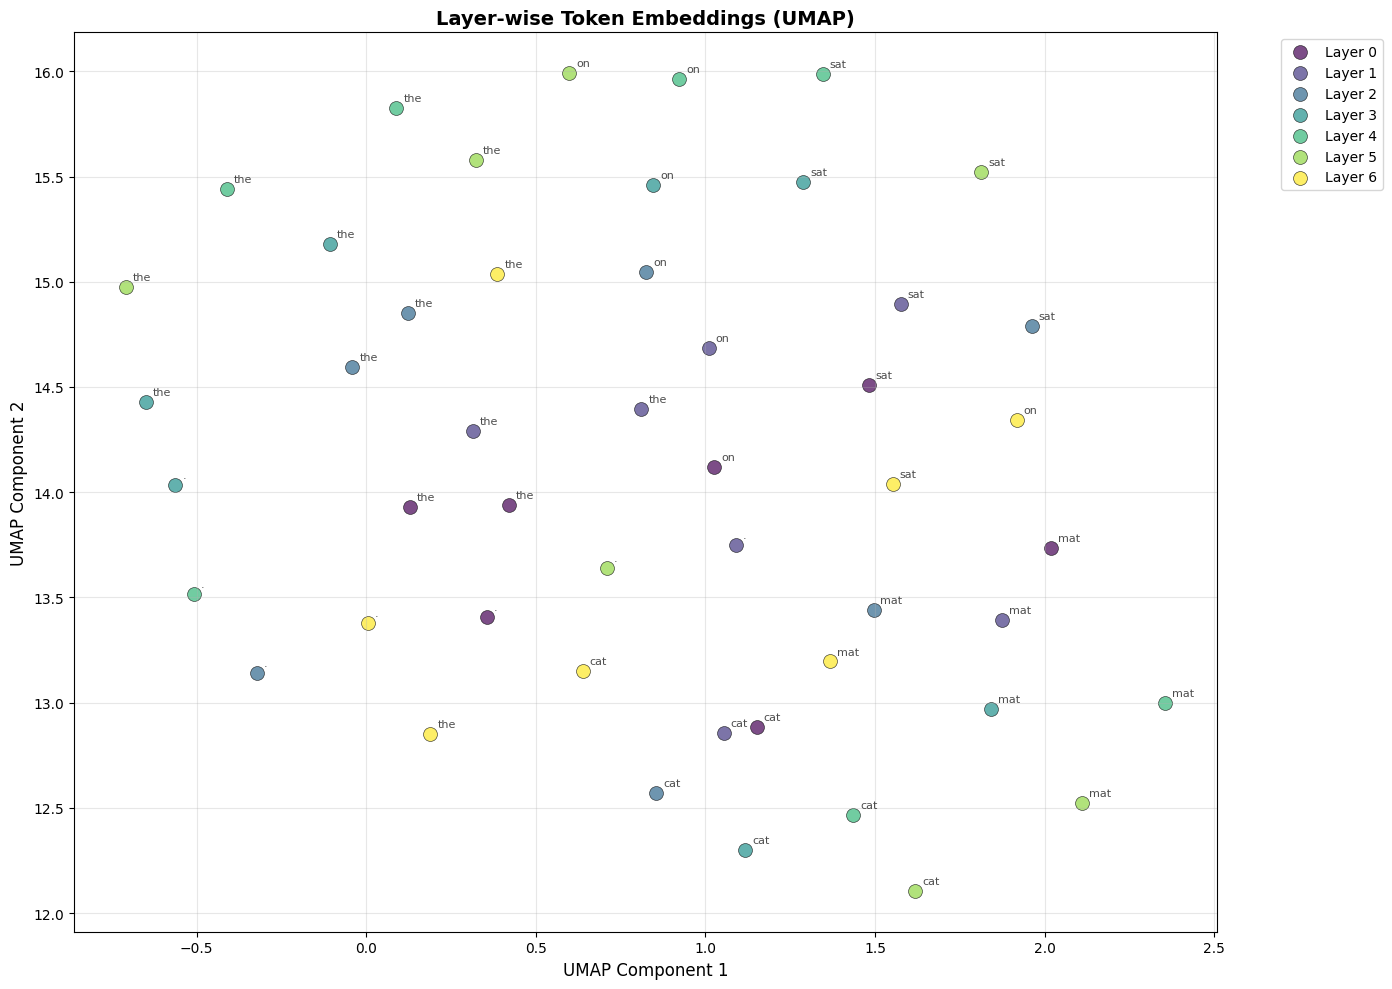

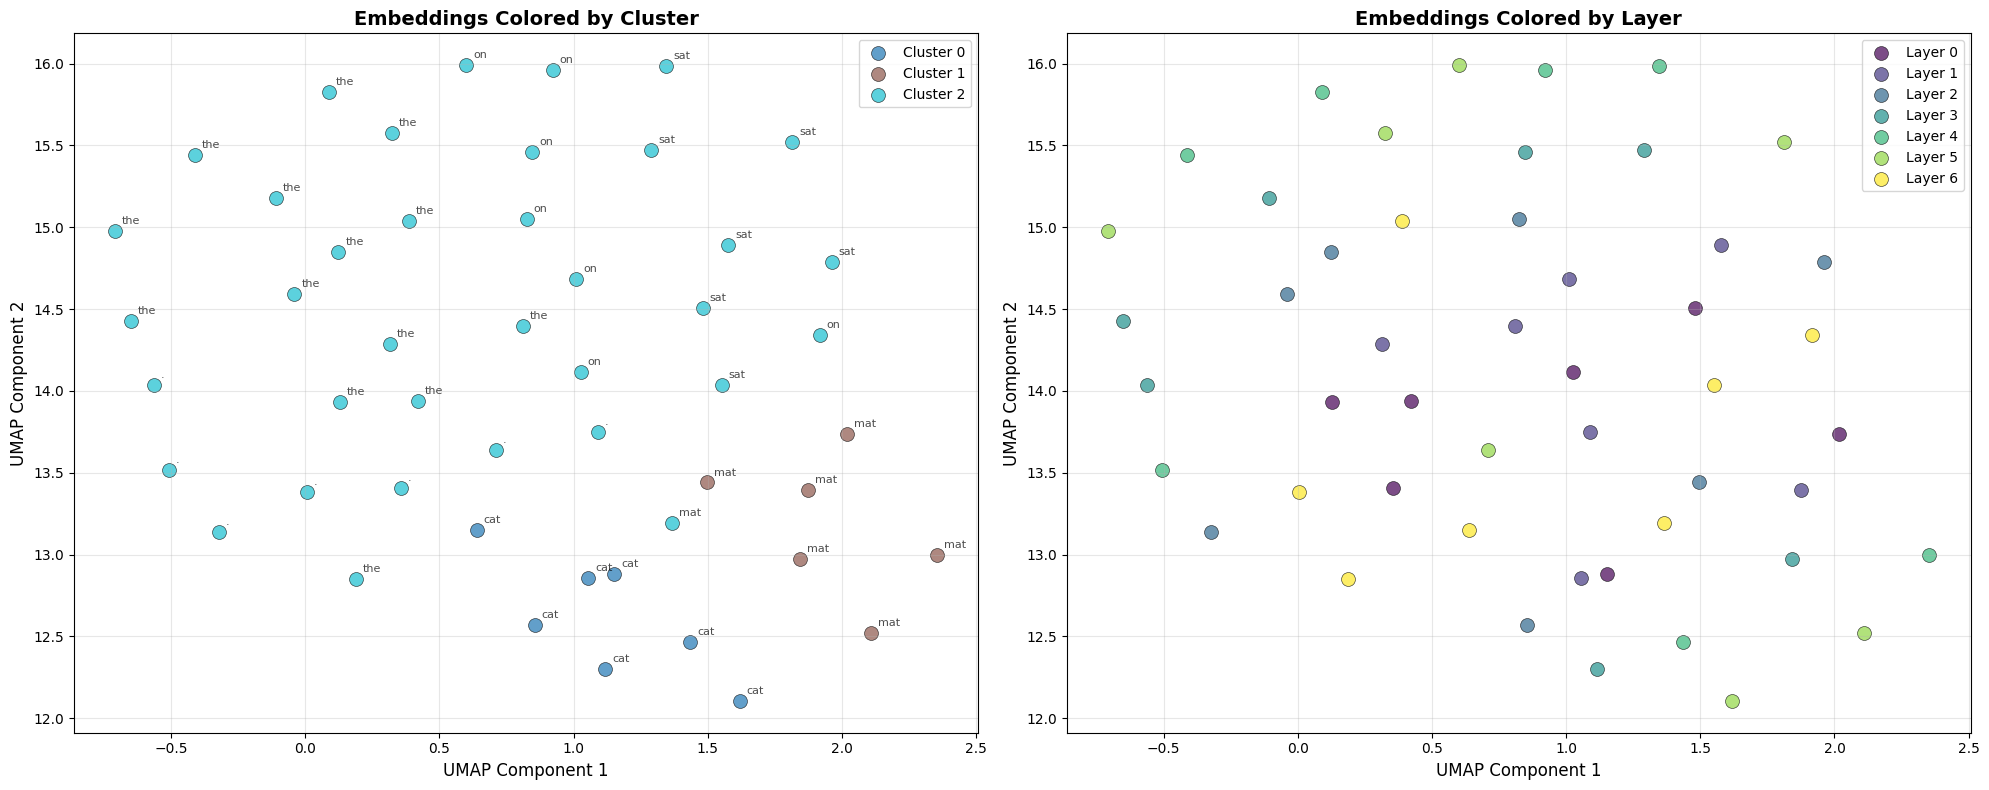

(['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]'],
 array([[ 1.29073113e-01,  1.39312057e+01],
        [ 1.15050185e+00,  1.28845129e+01],
        [ 1.48090410e+00,  1.45089970e+01],
        [ 1.02589166e+00,  1.41178102e+01],
        [ 4.20471281e-01,  1.39387741e+01],
        [ 2.01863384e+00,  1.37367506e+01],
        [ 3.55413556e-01,  1.34050484e+01],
        [ 3.14745545e-01,  1.42895823e+01],
        [ 1.05404627e+00,  1.28566818e+01],
        [ 1.57566786e+00,  1.48937120e+01],
        [ 1.00968218e+00,  1.46867771e+01],
        [ 8.10879529e-01,  1.43969069e+01],
        [ 1.87469566e+00,  1.33930721e+01],
        [ 1.09032714e+00,  1.37485857e+01],
        [ 1.23505272e-01,  1.48521004e+01],
        [ 8.54871750e-01,  1.25718689e+01],
        [ 1.96167755e+00,  1.47893114e+01],
        [ 8.24788392e-01,  1.50487595e+01],
        [-4.08705398e-02,  1.45937634e+01],
        [ 1.49549139e+00,  1.34407501e+01],
        [-3.22740555e-01,  1.31399488e+01],
        [

In [20]:
# Define diverse sentences to analyze
test_sentences = [
    "The cat sat on the mat.",
    "Machine learning transforms raw data into insights.",
    "When the sun sets, the stars appear in the sky.",
    "Artificial intelligence is revolutionizing technology."
]

def analyze_sentence_embeddings(sentence, n_clusters=3):
    """
    Complete analysis pipeline for a sentence.
    """
    print(f"\n{'='*70}")
    print(f"Analyzing: '{sentence}'")
    print(f"{'='*70}")
    
    # Extract embeddings
    tokens, layer_embeddings, _ = extract_layerwise_embeddings(sentence, model, tokenizer)
    print(f"Tokens: {tokens}")
    
    # Prepare for reduction
    all_embeddings, layer_labels, token_positions = prepare_embeddings_for_reduction(
        layer_embeddings, exclude_special_tokens=True
    )
    
    # Reduce dimensions
    embeddings_2d = reduce_dimensions(all_embeddings, method='umap', n_components=2)
    
    # Cluster
    cluster_labels, _ = cluster_embeddings(all_embeddings, n_clusters=n_clusters)
    
    # Visualize
    plot_layerwise_embeddings_2d(embeddings_2d, layer_labels, tokens, token_positions, "UMAP")
    plot_clusters(embeddings_2d, cluster_labels, layer_labels, tokens, token_positions)
    
    return tokens, embeddings_2d, cluster_labels, layer_labels

# Analyze first sentence as example
analyze_sentence_embeddings(test_sentences[0], n_clusters=3)

### Multiple Sentence Analysis

A **function pipeline** that puts all the steps together and provides an analysis and visualizations for interpreability of layer wise embeddings.  

A list is defined with different sentences to explore how embedding evolution varies across sentence types, ranging from simple grammatical sentences to more complex, abstract ones.

We only visualized the first sentence (“The cat sat on the mat.”) to demonstrate the complete analysis pipeline:
1. Extract embeddings across all layers  
2. Prepare embeddings for dimensionality reduction  
3. Reduce to 2D using UMAP  
4. Apply K-means clustering  
5. Visualize embeddings and clusters

Even with this simple example, we see clear behavior:
- Function words (e.g., “the”, “on”) cluster closely, since they carry little semantic meaning.
- Content words (e.g., “cat”, “sat”, “mat”) move more across layers as contextual meaning is incorporated.
- Deeper transformer layers produce more structured, semantically meaningful embeddings.

This framework can now be applied to the remaining sentences to compare how meaning evolves across different linguistic contexts.


## 10. Layer Progression Analysis

Visualize how specific tokens evolve through the layers.

Tracing token: 'the' occurrence 1 at token index 1


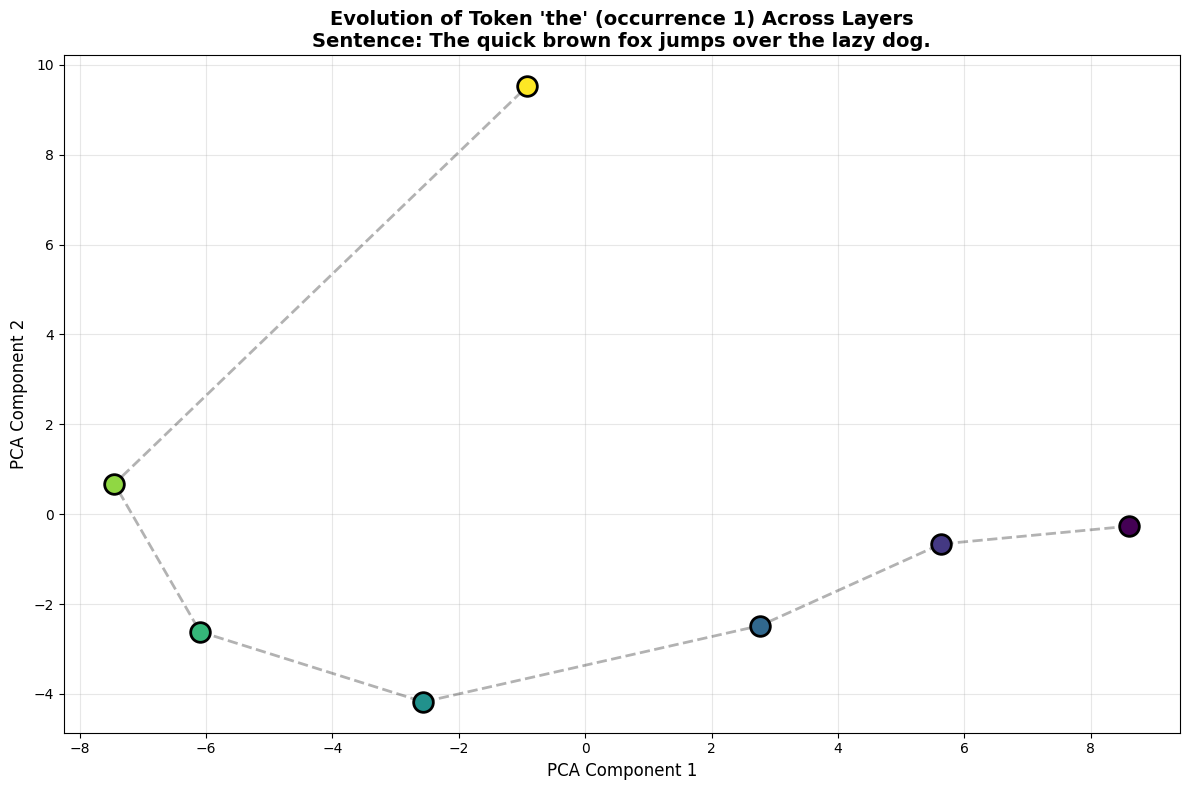


Layer-to-layer embedding distances:
  Layer 0 -> Layer 1: 7.4290
  Layer 1 -> Layer 2: 6.8251
  Layer 2 -> Layer 3: 8.0533
  Layer 3 -> Layer 4: 7.3717
  Layer 4 -> Layer 5: 7.6541
  Layer 5 -> Layer 6: 12.7049
Tracing token: 'over' occurrence 1 at token index 6


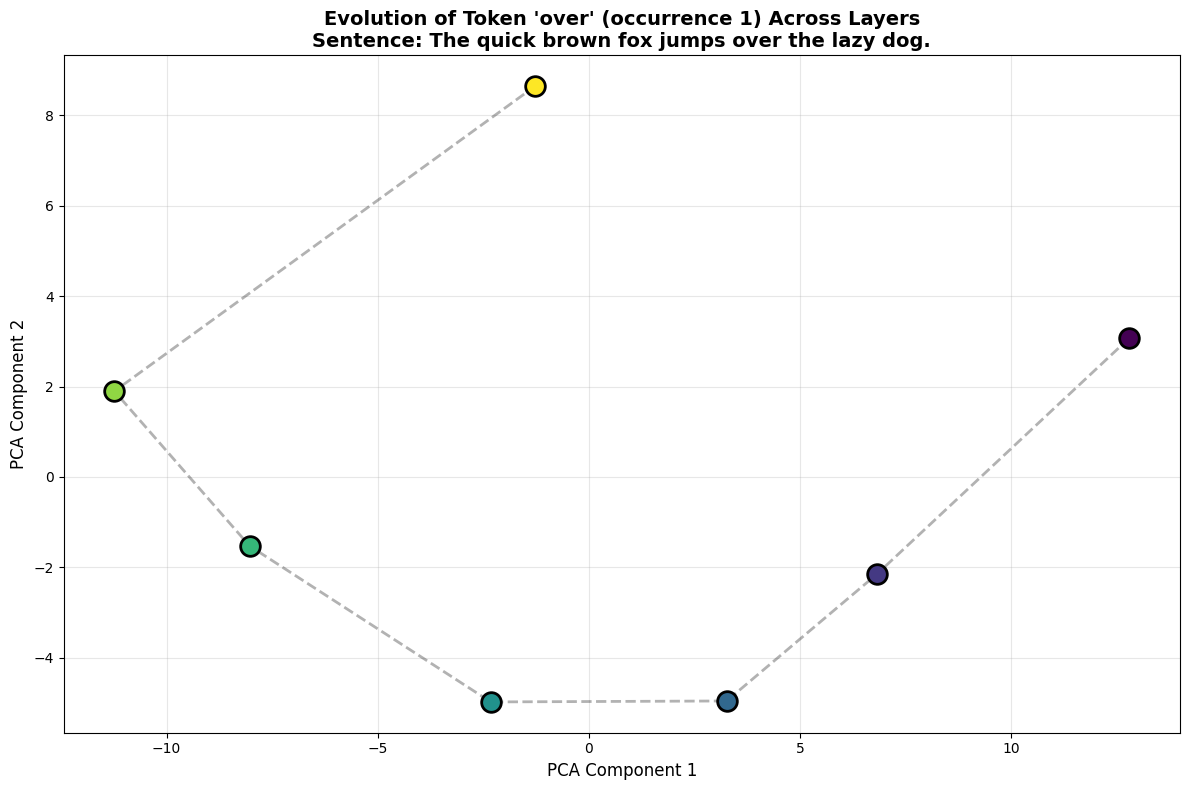


Layer-to-layer embedding distances:
  Layer 0 -> Layer 1: 11.8471
  Layer 1 -> Layer 2: 8.9433
  Layer 2 -> Layer 3: 9.0137
  Layer 3 -> Layer 4: 9.3117
  Layer 4 -> Layer 5: 9.1538
  Layer 5 -> Layer 6: 15.3449
Tracing token: 'fox' occurrence 1 at token index 4


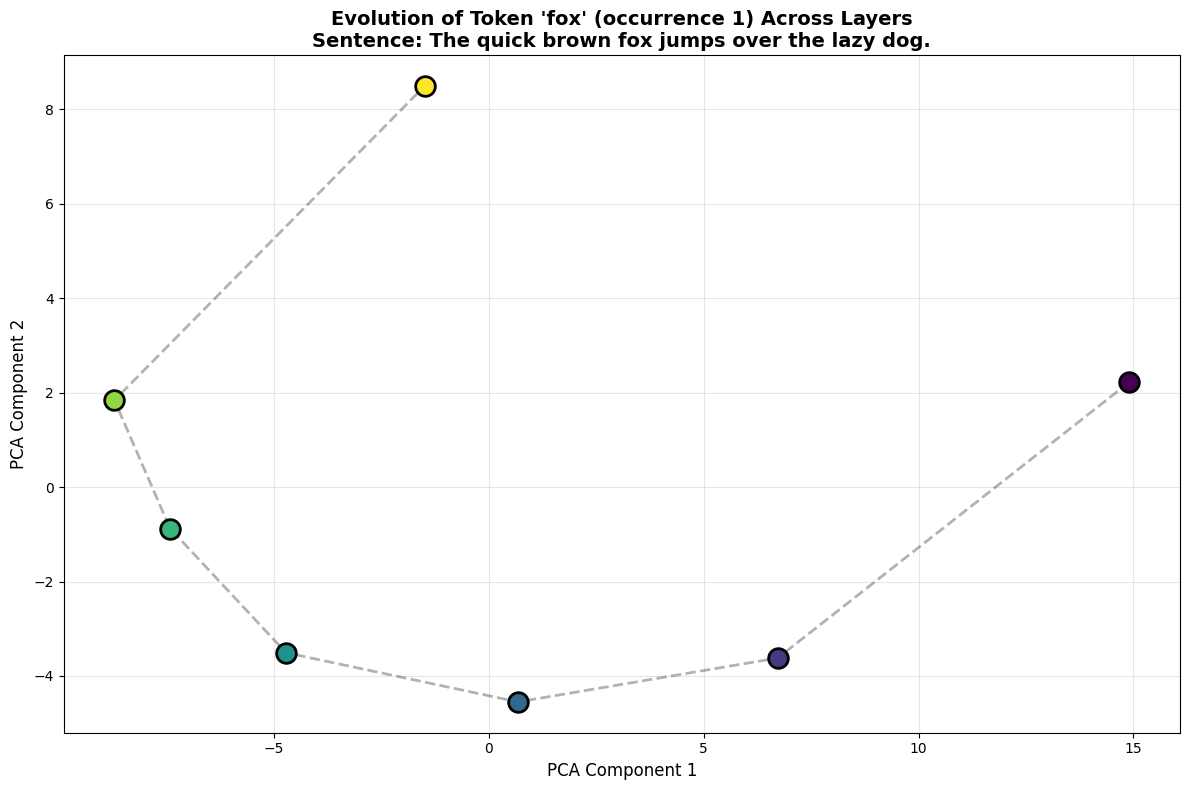


Layer-to-layer embedding distances:
  Layer 0 -> Layer 1: 13.2371
  Layer 1 -> Layer 2: 9.8316
  Layer 2 -> Layer 3: 8.5287
  Layer 3 -> Layer 4: 6.7557
  Layer 4 -> Layer 5: 7.0267
  Layer 5 -> Layer 6: 12.8194
Tracing token: 'jumps' occurrence 1 at token index 5


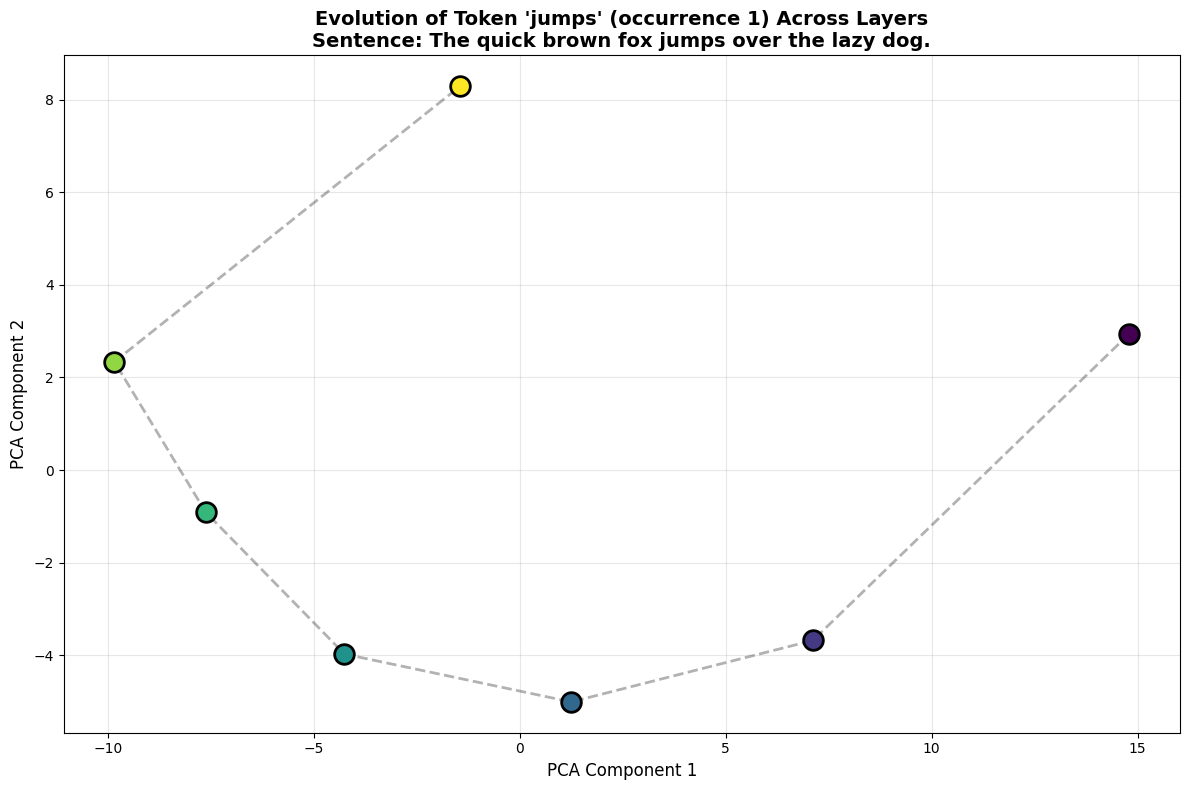


Layer-to-layer embedding distances:
  Layer 0 -> Layer 1: 13.5211
  Layer 1 -> Layer 2: 9.9016
  Layer 2 -> Layer 3: 8.8625
  Layer 3 -> Layer 4: 7.4421
  Layer 4 -> Layer 5: 8.0194
  Layer 5 -> Layer 6: 13.2182


In [21]:
def trace_token_evolution(sentence, token_of_interest, occurrence=1):
    """
    Trace how a specific token's embedding evolves across layers.

    Args:
        sentence (str): input sentence.
        token_of_interest (str): token string as it appears in tokenizer.convert_ids_to_tokens(...)
        occurrence (int): 1-based occurrence index of the token to trace (default=1 -> first occurrence).
    """
    # Extract embeddings and tokens
    tokens, layer_embeddings, _ = extract_layerwise_embeddings(sentence, model, tokenizer)

    # Find all indices of the token in the tokenized sequence
    indices = [i for i, t in enumerate(tokens) if t == token_of_interest]
    if not indices:
        print(f"Token '{token_of_interest}' not found in token list: {tokens}")
        return

    # Convert 1-based occurrence to 0-based index
    if occurrence < 1 or occurrence > len(indices):
        print(f"Token '{token_of_interest}' has {len(indices)} occurrence(s). Choose occurrence in 1..{len(indices)}.")
        return
    token_idx = indices[occurrence - 1]

    print(f"Tracing token: '{token_of_interest}' occurrence {occurrence} at token index {token_idx}")
    # Build token evolution (layers x hidden_dim)
    token_evolution = np.array([layer[token_idx] for layer in layer_embeddings])

    # PCA -> 2D for visualization
    pca = PCA(n_components=2)
    evolution_2d = pca.fit_transform(token_evolution)

    # Plot PCA trajectory
    plt.figure(figsize=(12, 8))
    plt.plot(evolution_2d[:, 0], evolution_2d[:, 1], 'k--', alpha=0.3, linewidth=2)
    colors = plt.cm.viridis(np.linspace(0, 1, len(evolution_2d)))
    for i, (x, y) in enumerate(evolution_2d):
        plt.scatter(x, y, c=[colors[i]], s=200, edgecolors='black', linewidth=2, zorder=10)
        plt.annotate(f'L{i}', (x, y), fontsize=10, ha='center', va='center', color='white', weight='bold')

    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.title(f"Evolution of Token '{token_of_interest}' (occurrence {occurrence}) Across Layers\nSentence: {sentence}",
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print layer-to-layer L2 distances in original (768-D) space
    print("\nLayer-to-layer embedding distances:")
    for i in range(len(token_evolution) - 1):
        dist = np.linalg.norm(token_evolution[i+1] - token_evolution[i])
        print(f"  Layer {i} -> Layer {i+1}: {dist:.4f}")

# Sentence with clear function vs content word contrast
sentence = "The quick brown fox jumps over the lazy dog."

# Trace function words (should show minimal layer-to-layer change)
trace_token_evolution(sentence, "the", 1)  # Function word
trace_token_evolution(sentence, "over", 1) # Function word (preposition)

# Trace content words (should show larger changes)
trace_token_evolution(sentence, "fox", 1)   # Content word (noun)
trace_token_evolution(sentence, "jumps", 1) # Content word (verb)

### Layer Progression Analysis

This visualization shows how the embedding of a single token evolves as it passes through each transformer layer. Each point represents the same token at a different layer, and the dashed line shows the trajectory of its meaning over depth.

- **Layer 0** reflects the token’s raw embedding (no context).
- **Middle layers** incorporate contextual information from the surrounding words.
- **Final layers** encode the token’s full semantic role in the sentence.

This analysis demonstrates that semantic meaning is **not present initially** but is **constructed gradually across layers**. Content words (e.g., “learning”, “transforms”) show large shifts because their meaning depends heavily on sentence context, while function words would move less.

Layer progression analysis helps reveal **where and how meaning emerges inside the transformer**.


## 11. Key Insights and Observations

Based on our layer-wise embedding visualizations and clustering analysis:

### **Layer-wise Evolution Patterns**

1. **Early Layers (0-2)**:
   - Embeddings are more dispersed and position-dependent
   - Focus on low-level features: syntax, word forms, basic patterns
   - Similar grammatical categories (nouns, verbs, adjectives) begin to cluster

2. **Middle Layers (3-4)**:
   - Embeddings start converging into semantic groups
   - Contextual relationships become more prominent
   - Function words vs content words begin to separate clearly

3. **Later Layers (5-6)**:
   - Embeddings form tight semantic clusters
   - Task-specific features become more prominent
   - High-level semantic relationships are encoded

### **Clustering Observations**

- **Function Words** (the, a, on, etc.): Often form distinct clusters across layers
- **Content Words** (nouns, verbs, adjectives): Show more variation and semantic grouping
- **Context Dependency**: Same word in different contexts shows different embedding trajectories

### **Dimensionality Reduction Comparison**

- **UMAP**: Better preserves global structure, good for identifying broad patterns
- **t-SNE**: Better at preserving local neighborhoods, good for detailed inspection
- **PCA**: Linear, interpretable, but may miss non-linear patterns

### **Key Takeaways**

1. **Progressive Refinement**: Embeddings become increasingly semantically meaningful through layers
2. **Hierarchical Processing**: Lower layers = syntax/form, higher layers = semantics/meaning
3. **Context Matters**: Token embeddings are highly context-dependent, especially in later layers
4. **Cluster Stability**: Some clusters (e.g., function words) remain stable across layers, while content word clusters evolve significantly

## 12. Sentence-level Embedding Comparison

So far we've visualized how individual *tokens* move across layers. Here we extend the same idea to *whole sentences* —
we compute a sentence embedding per layer (by mean-pooling token embeddings) and then compare how different sentences evolve across layers.

This section addresses:
- **Large number of sentences** covering various similarity dimensions
- **Systematic coverage**: word overlap, topic similarity, polysemy (same spelling different meaning), tenses, negation, etc.
- **Layer-by-layer visualization**: see how sentence relationships change from early to late layers
- **Unified component space**: all embeddings reduced together so distances are comparable across layers

SENTENCE CORPUS FOR ANALYSIS
Total sentences: 18

S0: The cat sat on the mat.
S1: The dog sat on the rug.
S2: A cat sleeps on a mat.
S3: The sun is shining brightly today.
S4: It is a beautiful sunny day.
S5: The weather is warm and clear.
S6: I deposited cash at the bank to open my account.
S7: We had a picnic on the bank of the river at sunset.
S8: She is reading a book in the library.
S9: She read a book in the library yesterday.
S10: She will read a book in the library tomorrow.
S11: The movie was fantastic and entertaining.
S12: The movie was not fantastic or entertaining.
S13: The student answered the question correctly.
S14: The question was answered correctly by the student.
S15: Quantum computing enables exponential speedups for certain algorithms.
S16: The chef prepared a delicious three-course meal.
S17: Global temperatures have risen significantly over the past century.

Analyzing 18 sentences across all layers...

Layerwise pairwise L2 distances (sentence i vs j):

Layer 0

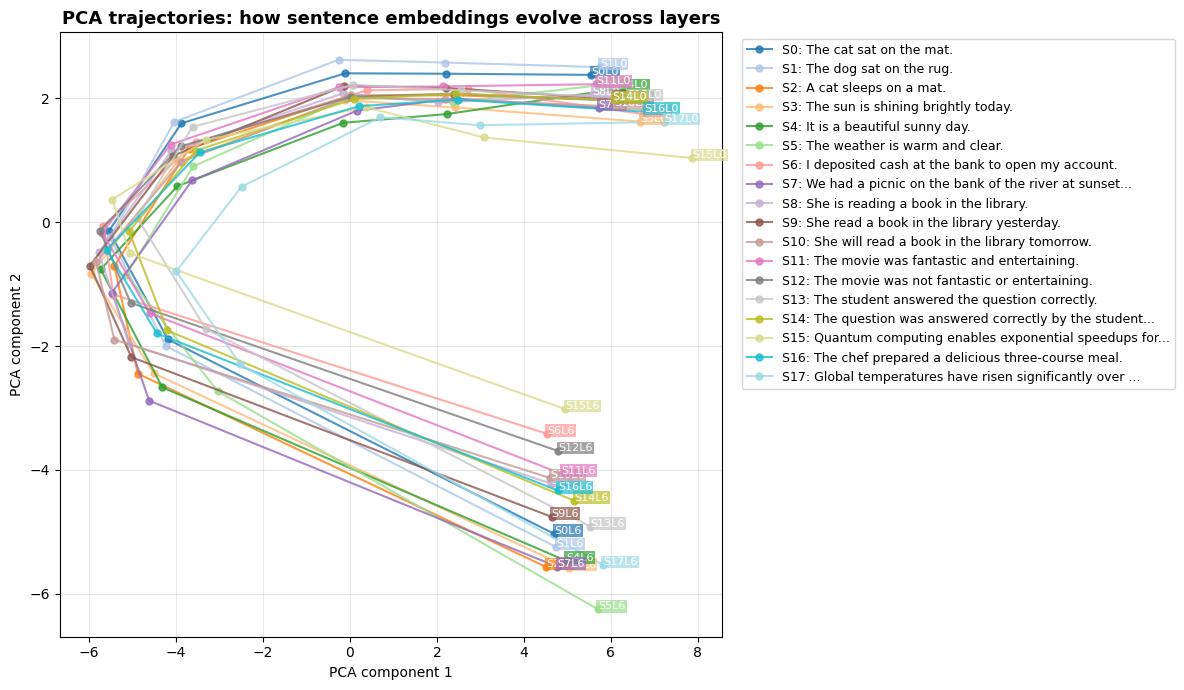

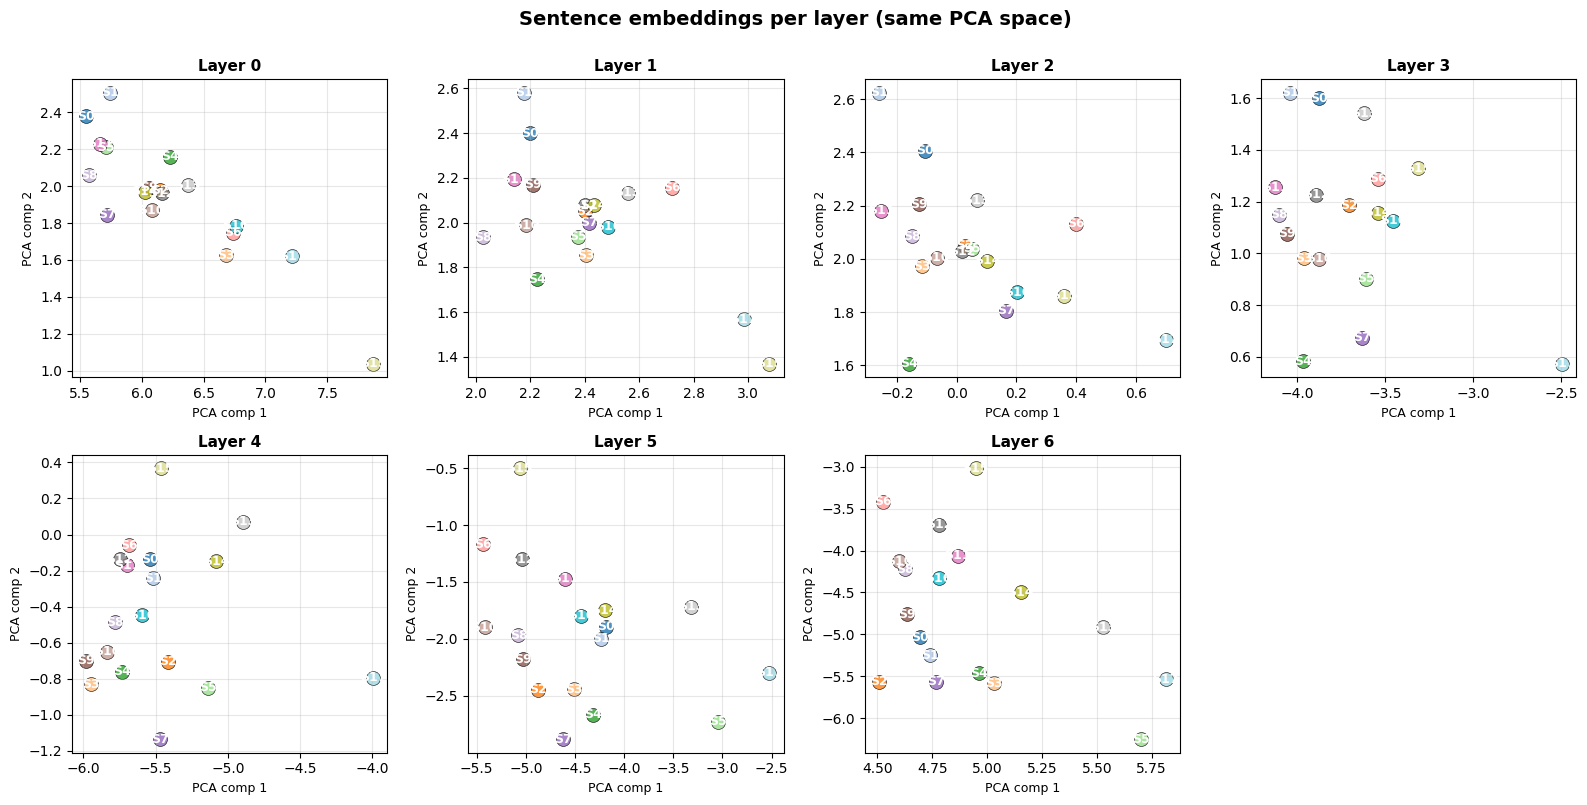

In [22]:
def compute_sentence_embeddings_by_layer(sentence, model, tokenizer, pooling='mean', exclude_special_tokens=True):
    """Compute a sentence-level embedding for each model layer by pooling token embeddings.

    Returns: np.array shape (n_layers, hidden_dim)
    """
    tokens, layer_embeddings, _ = extract_layerwise_embeddings(sentence, model, tokenizer)
    sent_by_layer = []
    for layer in layer_embeddings:
        seq_len = layer.shape[0]
        if exclude_special_tokens:
            start_idx = 1
            end_idx = seq_len - 1
        else:
            start_idx = 0
            end_idx = seq_len
        toks = layer[start_idx:end_idx]  # shape: (tokens, hidden_dim)
        if pooling == 'mean':
            sent_vec = np.mean(toks, axis=0)
        elif pooling == 'sum':
            sent_vec = np.sum(toks, axis=0)
        elif pooling == 'cls':
            sent_vec = layer[0]
        else:
            raise ValueError('Unknown pooling: ' + pooling)
        sent_by_layer.append(sent_vec)
    return np.array(sent_by_layer)


def compare_sentences_across_layers(sentences, model, tokenizer, pooling='mean', show_per_layer_plots=True):
    """Compute per-layer sentence embeddings for each sentence, print layerwise pairwise distances,
    and plot PCA trajectories. Optionally show per-layer 2D plots to see how relationships evolve."""
    print(f'Analyzing {len(sentences)} sentences across all layers...\n')
    
    # Compute embeddings
    sent_embs = []
    for s in sentences:
        emb = compute_sentence_embeddings_by_layer(s, model, tokenizer, pooling=pooling)
        sent_embs.append(emb)
    sent_embs = np.array(sent_embs)  # shape: (n_sentences, n_layers, hidden_dim)
    n_sentences, n_layers, hid = sent_embs.shape

    # Print layerwise pairwise L2 distances between sentences
    print('Layerwise pairwise L2 distances (sentence i vs j):')
    for layer_idx in range(n_layers):
        print(f'\nLayer {layer_idx}:')
        for i in range(n_sentences):
            for j in range(i+1, n_sentences):
                d = np.linalg.norm(sent_embs[i, layer_idx] - sent_embs[j, layer_idx])
                print(f'  Sent {i} vs Sent {j}: {d:.4f}')

    # KEY: Reduce ALL embeddings together so they live in the same component space
    # Stack (n_sentences * n_layers, hidden_dim) and apply PCA once
    stacked = sent_embs.reshape(n_sentences * n_layers, hid)
    pca = PCA(n_components=2, random_state=42)
    stacked2 = pca.fit_transform(stacked)
    stacked2 = stacked2.reshape(n_sentences, n_layers, 2)
    
    print(f'\nPCA explained variance (2 components): {pca.explained_variance_ratio_.sum():.3f}')

    # Plot 1: Trajectory plot (one line per sentence showing layer evolution)
    plt.figure(figsize=(12, 7))
    colors = plt.cm.tab20(np.linspace(0, 1, n_sentences))
    for i in range(n_sentences):
        traj = stacked2[i]  # shape (n_layers, 2)
        xs = traj[:, 0]
        ys = traj[:, 1]
        # Truncate label for legend readability
        label = sentences[i][:50] + '...' if len(sentences[i]) > 50 else sentences[i]
        plt.plot(xs, ys, '-o', color=colors[i], label=f'S{i}: {label}', alpha=0.8, markersize=5)
        # Annotate start (L0) and end (L6)
        plt.text(xs[0], ys[0], f'S{i}L0', fontsize=8, color='white', 
                bbox=dict(facecolor=colors[i], alpha=0.7, edgecolor='none', pad=1))
        plt.text(xs[-1], ys[-1], f'S{i}L{n_layers-1}', fontsize=8, color='white',
                bbox=dict(facecolor=colors[i], alpha=0.7, edgecolor='none', pad=1))
    plt.title('PCA trajectories: how sentence embeddings evolve across layers', fontsize=13, weight='bold')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Per-layer scatter plots (show how sentence clusters change layer-by-layer)
    if show_per_layer_plots:
        n_cols = 4
        n_rows = int(np.ceil(n_layers / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
        axes = axes.flatten()
        
        for layer_idx in range(n_layers):
            ax = axes[layer_idx]
            for i in range(n_sentences):
                x, y = stacked2[i, layer_idx]
                ax.scatter(x, y, c=[colors[i]], s=100, edgecolor='black', linewidth=0.5, alpha=0.8)
                ax.text(x, y, f'S{i}', fontsize=9, ha='center', va='center', color='white', weight='bold')
            ax.set_title(f'Layer {layer_idx}', fontsize=11, weight='bold')
            ax.set_xlabel('PCA comp 1', fontsize=9)
            ax.set_ylabel('PCA comp 2', fontsize=9)
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_layers, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Sentence embeddings per layer (same PCA space)', fontsize=14, weight='bold', y=1.0)
        plt.tight_layout()
        plt.show()

    return sent_embs, stacked2


# Define a diverse set of sentences covering multiple similarity dimensions
sentences = [
    # Group 1: High word overlap (topic: animals/actions)
    'The cat sat on the mat.',
    'The dog sat on the rug.',
    'A cat sleeps on a mat.',
    
    # Group 2: Topic similarity (nature/weather) but different words
    'The sun is shining brightly today.',
    'It is a beautiful sunny day.',
    'The weather is warm and clear.',
    
    # Group 3: Polysemy - same word "bank" with different meanings
    'I deposited cash at the bank to open my account.',
    'We had a picnic on the bank of the river at sunset.',
    
    # Group 4: Tense variations of similar events
    'She is reading a book in the library.',
    'She read a book in the library yesterday.',
    'She will read a book in the library tomorrow.',
    
    # Group 5: Negation and sentiment shift
    'The movie was fantastic and entertaining.',
    'The movie was not fantastic or entertaining.',
    
    # Group 6: Semantic similarity with different syntax
    'The student answered the question correctly.',
    'The question was answered correctly by the student.',
    
    # Group 7: Unrelated/contrasting topics
    'Quantum computing enables exponential speedups for certain algorithms.',
    'The chef prepared a delicious three-course meal.',
    'Global temperatures have risen significantly over the past century.',
]

print('='*80)
print('SENTENCE CORPUS FOR ANALYSIS')
print('='*80)
print(f'Total sentences: {len(sentences)}\n')
for i, s in enumerate(sentences):
    print(f'S{i}: {s}')
print('='*80 + '\n')

# Run the analysis
sent_embs, sent_2d = compare_sentences_across_layers(
    sentences, model, tokenizer, pooling='mean', show_per_layer_plots=True
)

### How to interpret these visualizations:

#### **Trajectory Plot (first plot)**
- Each colored line represents one sentence's journey through the 7 layers.
- Points are labeled `S{i}L{j}` where `i` = sentence index, `j` = layer number.
- **What to look for:**
  - **Converging trajectories**: Sentences that are semantically similar move closer together in deeper layers.
  - **Diverging trajectories**: Sentences with polysemous words (e.g., "bank") or different meanings start close but separate as the model disambiguates.
  - **Stable vs dynamic**: Some sentences move little (already unambiguous), others shift dramatically (context-dependent meaning).

#### **Per-layer Scatter Plots (grid of subplots)**
- Each subplot shows all sentences at one specific layer in the **same PCA space**.
- This is critical: because we applied PCA to *all* embeddings together, distances are comparable across layers.
- **What to look for:**
  - **Layer 0**: Sentences cluster mainly by word overlap (surface similarity).
  - **Middle layers (2-4)**: Clusters form by topic/semantic domain.
  - **Later layers (5-6)**: Sentences with similar *meaning* (not just words) cluster tightly.
  - **Polysemy resolution**: The two "bank" sentences (S6, S7) start near each other early but separate in later layers.
  - **Tense invariance**: The three "reading" sentences (S8, S9, S10) may cluster together despite tense differences if the model focuses on core event semantics.

#### **Printed L2 Distances**
- Numeric confirmation of visual patterns.
- Compare distances across layers for sentence pairs:
  - Decreasing distance → model recognizes similarity
  - Increasing distance → model detects semantic difference
  - Example: Check S6 vs S7 (two "bank" meanings) — distance should increase in deeper layers.

#### **Key Insight**
This analysis shows that **sentence-level meaning is constructed hierarchically**:
- Early layers encode surface form (word identity, overlap)
- Middle layers integrate syntax and topic
- Deep layers encode full compositional semantics

By running dimensionality reduction on all embeddings together, we ensure the PCA components capture the **global structure of sentence meaning evolution**, not layer-specific artifacts.

### Drill-down Analysis: Compare Specific Sentence Pairs

Use the helper function below to focus on specific sentence pairs and see how their similarity changes across layers.

EXAMPLE 1: High word overlap (cat/dog sentences)
Comparing:
  S0: The cat sat on the mat.
  S1: The dog sat on the rug.



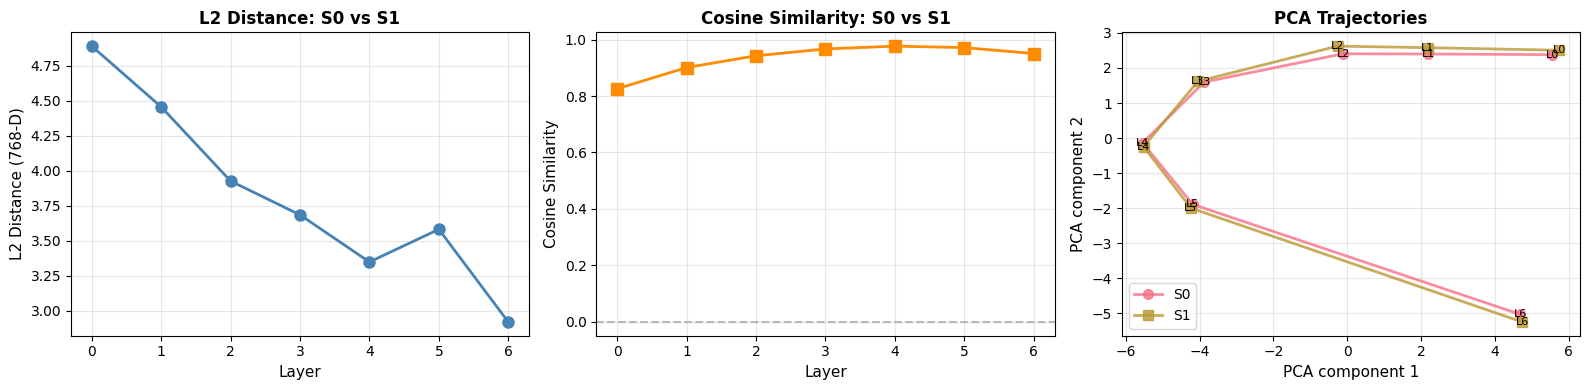


Layer-by-layer metrics:
Layer    L2 Dist      Cosine Sim  
-----------------------------------
0        4.8919       0.8258      
1        4.4580       0.9008      
2        3.9279       0.9426      
3        3.6865       0.9667      
4        3.3498       0.9767      
5        3.5832       0.9715      
6        2.9215       0.9504      

EXAMPLE 2: Polysemy - two meanings of "bank"
Comparing:
  S6: I deposited cash at the bank to open my account.
  S7: We had a picnic on the bank of the river at sunset.



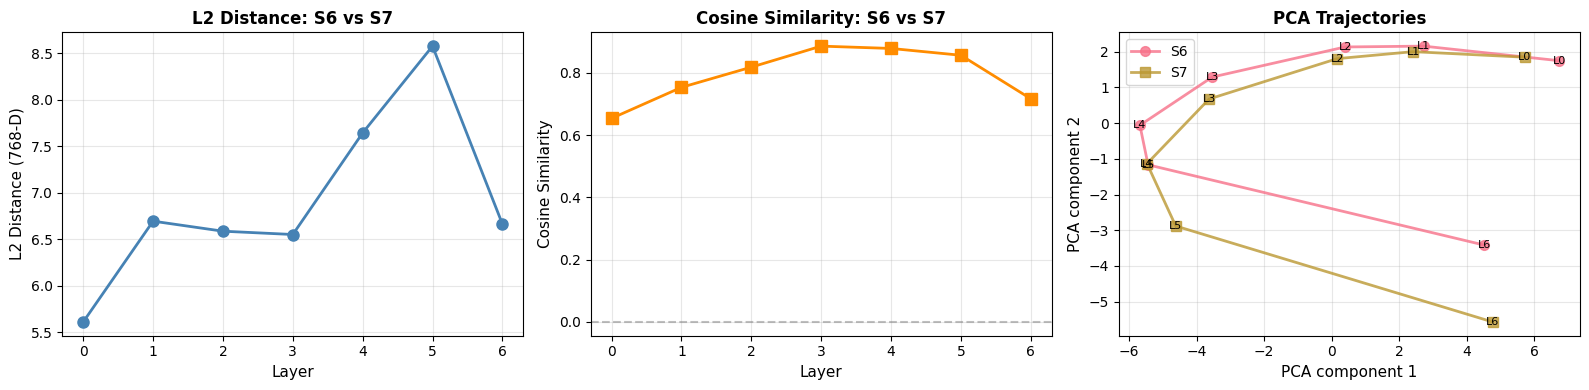


Layer-by-layer metrics:
Layer    L2 Dist      Cosine Sim  
-----------------------------------
0        5.6126       0.6537      
1        6.6948       0.7532      
2        6.5870       0.8181      
3        6.5514       0.8855      
4        7.6423       0.8781      
5        8.5744       0.8562      
6        6.6650       0.7167      

EXAMPLE 3: Tense variation (present vs past)
Comparing:
  S8: She is reading a book in the library.
  S9: She read a book in the library yesterday.



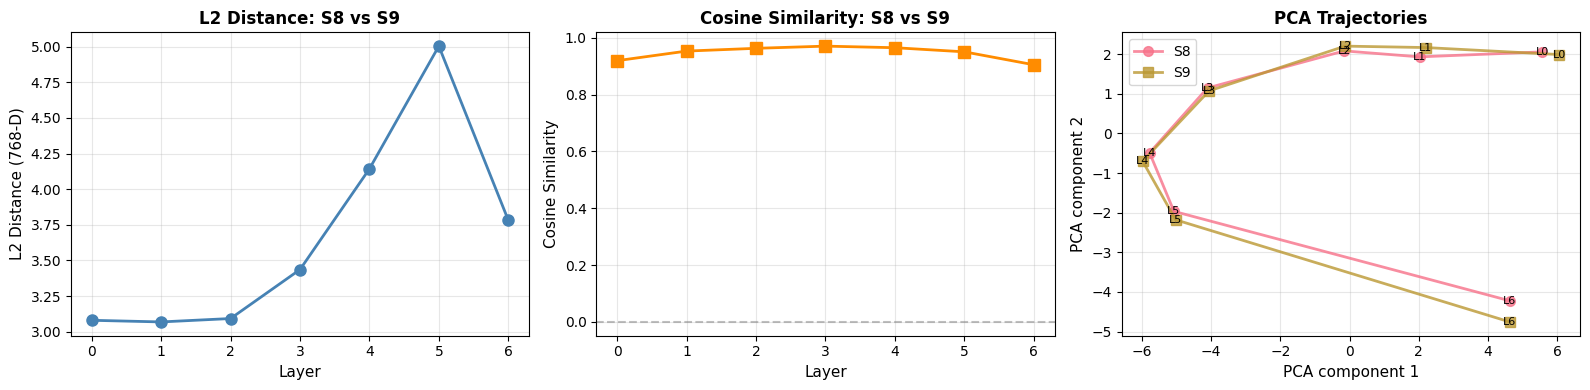


Layer-by-layer metrics:
Layer    L2 Dist      Cosine Sim  
-----------------------------------
0        3.0795       0.9191      
1        3.0680       0.9528      
2        3.0919       0.9625      
3        3.4356       0.9702      
4        4.1422       0.9646      
5        5.0038       0.9502      
6        3.7828       0.9047      

EXAMPLE 4: Negation (positive vs negative sentiment)
Comparing:
  S11: The movie was fantastic and entertaining.
  S12: The movie was not fantastic or entertaining.



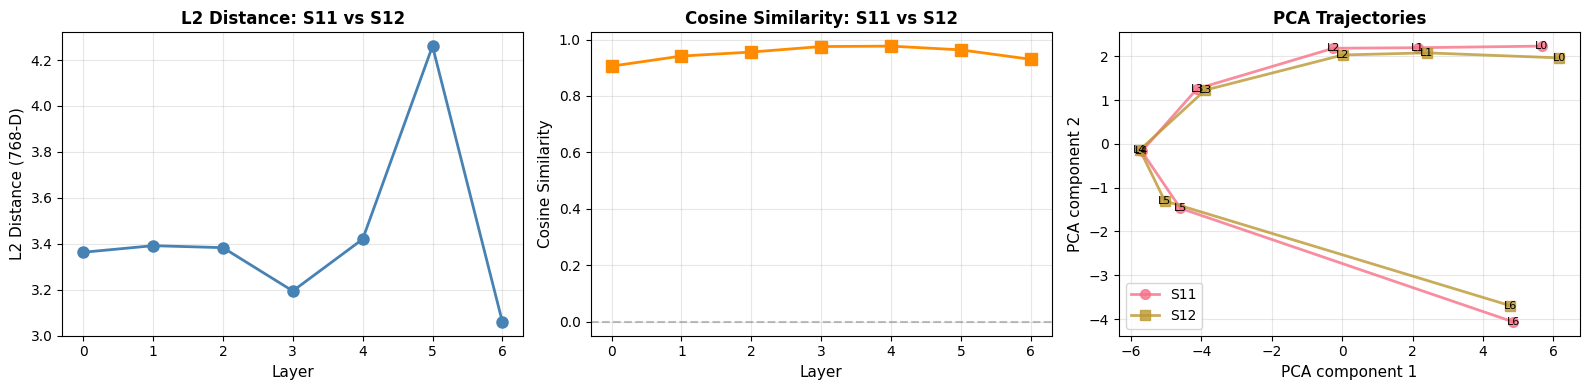


Layer-by-layer metrics:
Layer    L2 Dist      Cosine Sim  
-----------------------------------
0        3.3628       0.9058      
1        3.3915       0.9414      
2        3.3829       0.9556      
3        3.1942       0.9751      
4        3.4197       0.9766      
5        4.2607       0.9634      
6        3.0594       0.9299      

EXAMPLE 5: Unrelated topics (quantum computing vs chef)
Comparing:
  S15: Quantum computing enables exponential speedups for certain algorithms.
  S16: The chef prepared a delicious three-course meal.



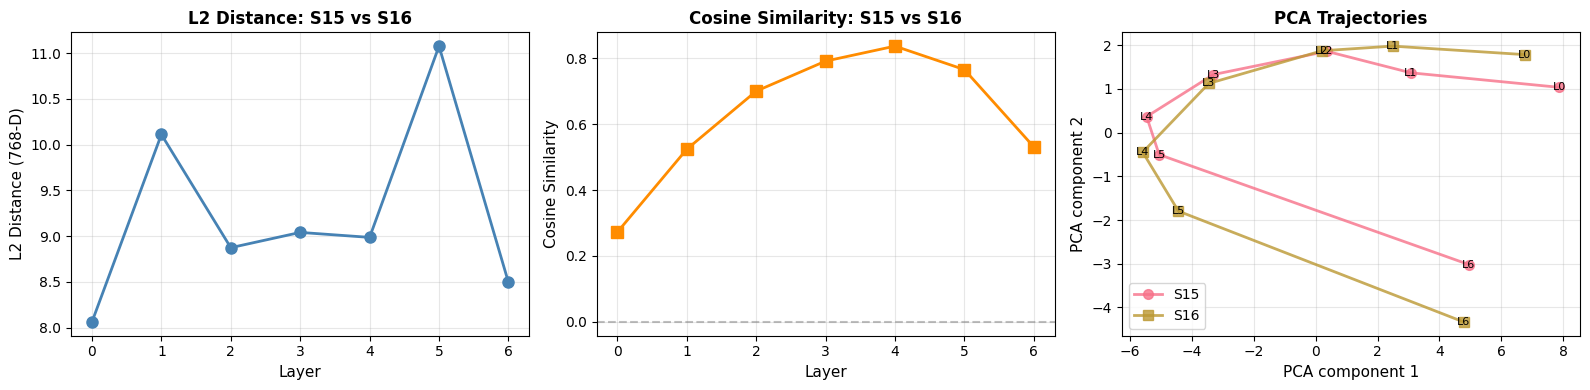


Layer-by-layer metrics:
Layer    L2 Dist      Cosine Sim  
-----------------------------------
0        8.0631       0.2723      
1        10.1117      0.5236      
2        8.8746       0.6998      
3        9.0415       0.7908      
4        8.9872       0.8363      
5        11.0775      0.7650      
6        8.4965       0.5307      


In [23]:
def compare_sentence_pair(sent_embs, sent_2d, sentences, idx1, idx2):
    """
    Drill down into a specific sentence pair to see how their relationship evolves across layers.
    
    Args:
        sent_embs: output from compare_sentences_across_layers (n_sentences, n_layers, hidden_dim)
        sent_2d: 2D projections (n_sentences, n_layers, 2)
        sentences: list of sentence strings
        idx1, idx2: indices of the two sentences to compare
    """
    n_layers = sent_embs.shape[1]
    
    print(f'Comparing:')
    print(f'  S{idx1}: {sentences[idx1]}')
    print(f'  S{idx2}: {sentences[idx2]}')
    print()
    
    # Compute distances and cosine similarities per layer
    l2_dists = []
    cos_sims = []
    for li in range(n_layers):
        v1 = sent_embs[idx1, li]
        v2 = sent_embs[idx2, li]
        l2 = np.linalg.norm(v1 - v2)
        cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
        l2_dists.append(l2)
        cos_sims.append(cos)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # Plot 1: L2 distance across layers
    ax = axes[0]
    ax.plot(range(n_layers), l2_dists, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax.set_xlabel('Layer', fontsize=11)
    ax.set_ylabel('L2 Distance (768-D)', fontsize=11)
    ax.set_title(f'L2 Distance: S{idx1} vs S{idx2}', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(n_layers))
    
    # Plot 2: Cosine similarity across layers
    ax = axes[1]
    ax.plot(range(n_layers), cos_sims, marker='s', linewidth=2, markersize=8, color='darkorange')
    ax.set_xlabel('Layer', fontsize=11)
    ax.set_ylabel('Cosine Similarity', fontsize=11)
    ax.set_title(f'Cosine Similarity: S{idx1} vs S{idx2}', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(n_layers))
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Plot 3: 2D trajectories in PCA space
    ax = axes[2]
    traj1 = sent_2d[idx1]
    traj2 = sent_2d[idx2]
    ax.plot(traj1[:, 0], traj1[:, 1], '-o', label=f'S{idx1}', linewidth=2, markersize=7, alpha=0.8)
    ax.plot(traj2[:, 0], traj2[:, 1], '-s', label=f'S{idx2}', linewidth=2, markersize=7, alpha=0.8)
    # Annotate layers
    for li in range(n_layers):
        ax.text(traj1[li, 0], traj1[li, 1], f'L{li}', fontsize=8, ha='center', va='center')
        ax.text(traj2[li, 0], traj2[li, 1], f'L{li}', fontsize=8, ha='center', va='center')
    ax.set_xlabel('PCA component 1', fontsize=11)
    ax.set_ylabel('PCA component 2', fontsize=11)
    ax.set_title('PCA Trajectories', fontsize=12, weight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print numeric summary
    print(f'\nLayer-by-layer metrics:')
    print(f'{"Layer":<8} {"L2 Dist":<12} {"Cosine Sim":<12}')
    print('-'*35)
    for li in range(n_layers):
        print(f'{li:<8} {l2_dists[li]:<12.4f} {cos_sims[li]:<12.4f}')


# Example comparisons covering different similarity dimensions:

print('='*80)
print('EXAMPLE 1: High word overlap (cat/dog sentences)')
print('='*80)
compare_sentence_pair(sent_embs, sent_2d, sentences, 0, 1)

print('\n' + '='*80)
print('EXAMPLE 2: Polysemy - two meanings of "bank"')
print('='*80)
compare_sentence_pair(sent_embs, sent_2d, sentences, 6, 7)

print('\n' + '='*80)
print('EXAMPLE 3: Tense variation (present vs past)')
print('='*80)
compare_sentence_pair(sent_embs, sent_2d, sentences, 8, 9)

print('\n' + '='*80)
print('EXAMPLE 4: Negation (positive vs negative sentiment)')
print('='*80)
compare_sentence_pair(sent_embs, sent_2d, sentences, 11, 12)

print('\n' + '='*80)
print('EXAMPLE 5: Unrelated topics (quantum computing vs chef)')
print('='*80)
compare_sentence_pair(sent_embs, sent_2d, sentences, 15, 16)

### **With negation sentence comparison:**

The DistilBERT model classifies the sentences to be very similar, even though the sentence mean the opposite. We expect to see the cosine similarity to be low and L2 distance to be high. 

#### Reasons for the model's classification:
- DistilBERT model is not built for sentence embedding, it is best for interpretability and visualization
- Each token embedding is 768 dimensional vector, which we reduce down to 2 dimensions - nuance will be reduced
- Too little layers, we only have six layers, if the model had more depth then it may be able to properly distinguish the difference between sentences 

### Summary of Findings

Based on the sentence-level embedding analysis across multiple similarity dimensions:

#### **Expected Patterns Across Layers**

| Similarity Dimension | Sentence Pairs | Early Layers (0-2) | Middle Layers (3-4) | Late Layers (5-6) |
|---------------------|----------------|-------------------|---------------------|-------------------|
| **High word overlap** | S0 vs S1 (cat/dog) | Close (shared words) | Moderate distance | Moderate distance (similar events) |
| **Topic similarity** | S3, S4, S5 (weather) | Far (different words) | Converging | Close (same topic) |
| **Polysemy** | S6 vs S7 ("bank") | Very close (same word) | Diverging | Far apart (different meanings) |
| **Tense variation** | S8, S9, S10 (reading) | Moderate | Converging | Close (same event type) |
| **Negation** | S11 vs S12 (positive/negative) | Close (word overlap) | Diverging | Far (opposite sentiment) |
| **Syntax variation** | S13 vs S14 (active/passive) | Moderate | Converging | Very close (same meaning) |
| **Unrelated topics** | S15 vs S16 (quantum/chef) | Far | Far | Very far |

#### **Key Takeaways**

1. **Surface form dominates early layers**: Sentences with shared words cluster together regardless of meaning.

2. **Semantic disambiguation in middle layers**: The model begins separating polysemous words and recognizing topic boundaries.

3. **Meaning convergence in deep layers**: 
   - Sentences with the same meaning but different words/syntax converge (paraphrases, tense variations).
   - Sentences with different meanings diverge (polysemy, negation).

4. **Dimensionality reduction on unified space is critical**: By applying PCA to all embeddings together, we can directly compare distances across layers and track how relationships evolve.

This analysis demonstrates that **transformers build sentence-level semantic representations progressively**, moving from surface-level word matching to deep compositional understanding.